In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import statsmodels.formula.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [4]:
pd.set_option('display.max_columns', 100)

In [5]:
kc = pd.read_csv('kc_house_data_train.csv')

In [6]:
def engineering(dataframe):
    dataframe['date'] = dataframe['date'].map(lambda x: x[:8]) # Removes 'T000000' from end of each date
    dataframe['date'] = pd.to_datetime(dataframe['date'], format = '%Y%M%d', errors = 'coerce')


    dataframe['bedrooms'] = np.where((dataframe['bedrooms'] + 1)/(dataframe['bathrooms'] + 1) > 4, 
                                      dataframe['bedrooms'].median(), 
                                      dataframe['bedrooms']) # Taking care of outliers in bedrooms

    dataframe['bathrooms'] = np.where((dataframe['bathrooms'] + 1)/(dataframe['bedrooms'] + 1) > 4,
                                       dataframe['bathrooms'].median(), 
                                       dataframe['bathrooms']) # Taking care of outliers in bathrooms

    dataframe['sale_yr'] = dataframe['date'].dt.year # New column using only year component of date column
    
    dataframe['home_age'] = dataframe['sale_yr'] - dataframe['yr_built']
    
    dataframe['home_age'] = np.where(dataframe['home_age'] == -1, 
                                     0, 
                                     dataframe['home_age']) # Removing rows where year built was after year sold

    dataframe['yr_renovated'] = np.where(dataframe['yr_renovated'] > dataframe['sale_yr'], 
                                         dataframe['sale_yr'], 
                                         dataframe['yr_renovated']) # Removing rows where year renovated was after year sold
        
    dataframe['yrs_since_reno'] = np.where(dataframe['yr_renovated'] != 0, 
                                           dataframe['sale_yr'] - dataframe['yr_renovated'], 
                                           dataframe['home_age']) # Creates yrs_since_reno col depending on if house was renovated

    ohe = pd.get_dummies(dataframe['zipcode']) #step 2 of engineering/cleaning before adding nnp cols
    dataframe = dataframe.join(ohe)
    
    dataframe['sqrt_grade'] = np.sqrt(dataframe['grade'])
    
    dataframe['coords'] = dataframe.apply(lambda x: list([x['lat'], x['long']]), axis = 1)

    
    
    return dataframe

In [ ]:
def cleaning(dataframe):
    dataframe = dataframe.drop(columns = ['id', 'date', 'zipcode', 'lat', 'long', 
                                'yr_renovated', 'sale_yr', 'yr_built'])

In [10]:
# kc1 = engineering(kc)
kc1.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,sale_yr,home_age,yrs_since_reno,98001,98002,98003,98004,98005,98006,98007,98008,98010,98011,98014,98019,98022,98023,98024,98027,98028,98029,98030,98031,98032,98033,98034,98038,98039,98040,98042,98045,98052,98053,98055,98056,98058,98059,98065,98070,98072,98074,98075,98077,98092,98102,98103,98105,98106,98107,98108,98109,98112,98115,98116,98117,98118,98119,98122,98125,98126,98133,98136,98144,98146,98148,98155,98166,98168,98177,98178,98188,98198,98199,sqrt_grade,coords
0,2591820310,2014-01-06 00:10:00,365000.0,4.0,2.25,2070,8893,2.0,0,0,4,8,2070,0,1986,0,98058,47.4388,-122.162,2390,7700,2014,28,28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2.828427,"[47.4388, -122.162]"
1,7974200820,2014-01-21 00:08:00,865000.0,5.0,3.00,2900,6730,1.0,0,0,5,8,1830,1070,1977,0,98115,47.6784,-122.285,2370,6283,2014,37,37,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2.828427,"[47.6784, -122.285]"
2,7701450110,2014-01-15 00:08:00,1038000.0,4.0,2.50,3770,10893,2.0,0,2,3,11,3770,0,1997,0,98006,47.5646,-122.129,3710,9685,2014,17,17,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3.316625,"[47.5646, -122.129]"
3,9522300010,2015-01-31 00:03:00,1490000.0,3.0,3.50,4560,14608,2.0,0,2,3,12,4560,0,1990,0,98034,47.6995,-122.228,4050,14226,2015,25,25,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3.464102,"[47.6995, -122.228]"
4,9510861140,2014-01-14 00:07:00,711000.0,3.0,2.50,2550,5376,2.0,0,0,3,9,2550,0,2004,0,98052,47.6647,-122.083,2250,4050,2014,10,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3.000000,"[47.6647, -122.083]"


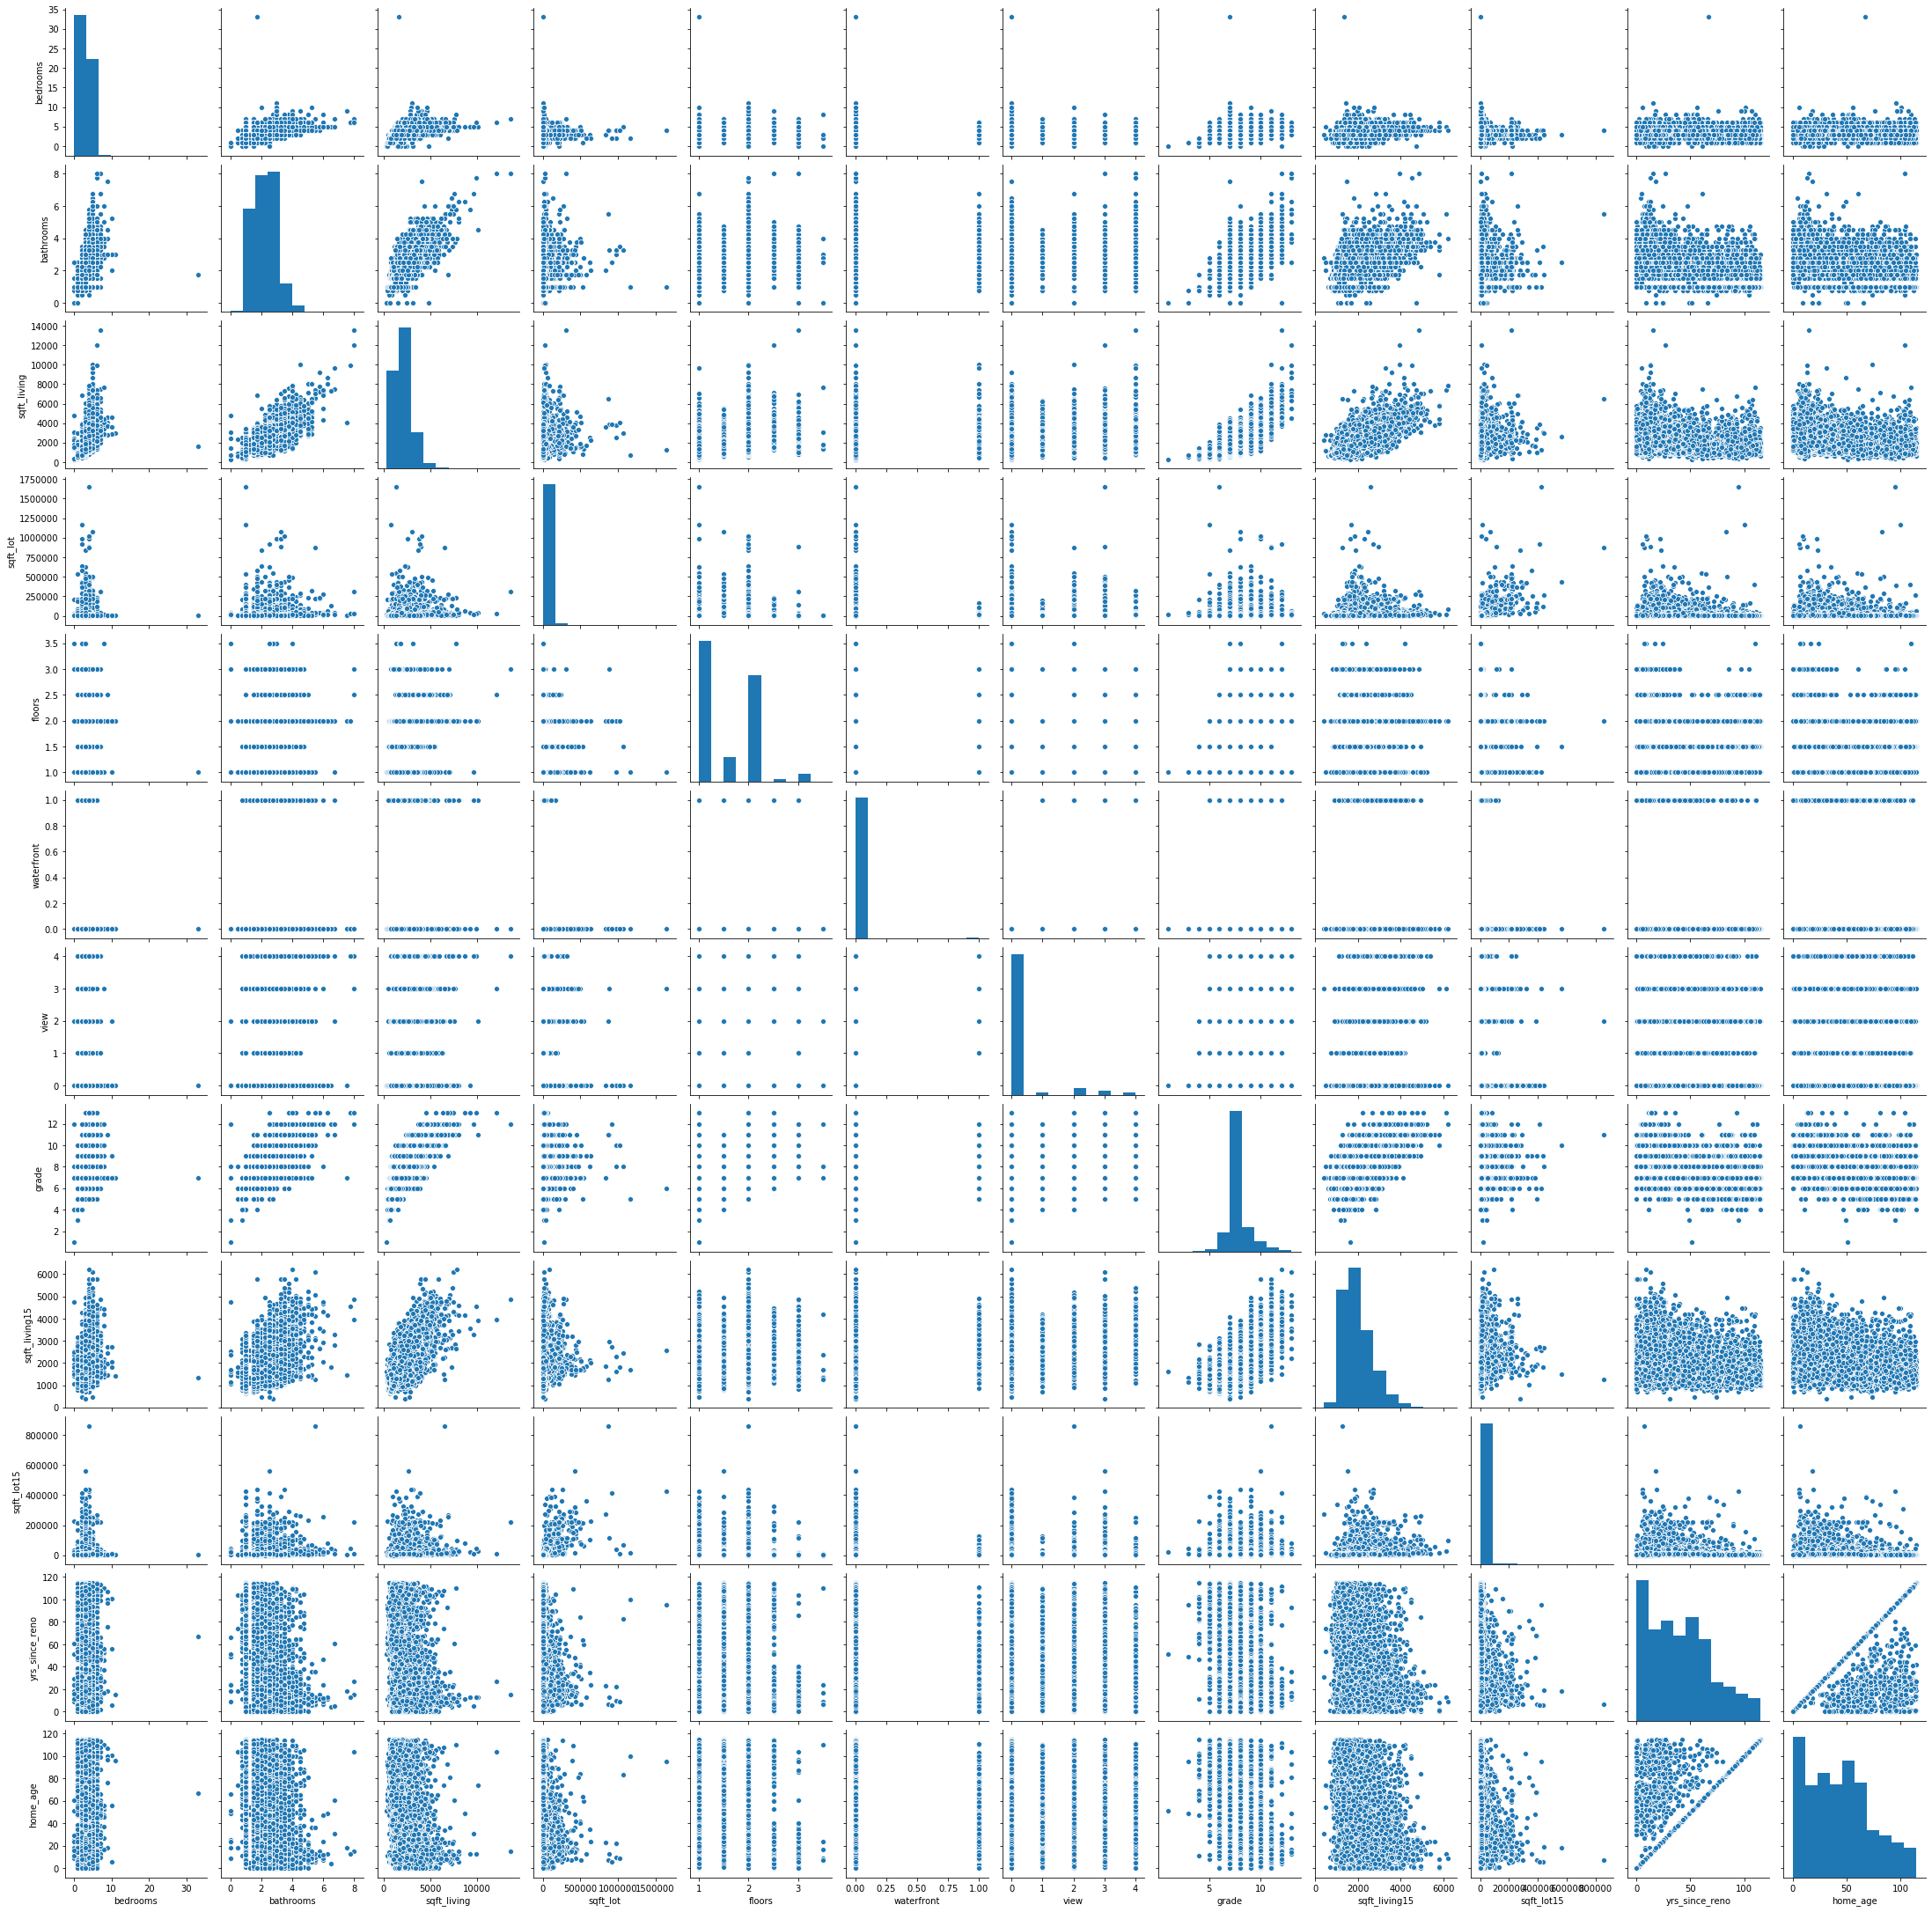

In [77]:
sns.pairplot(predictors)

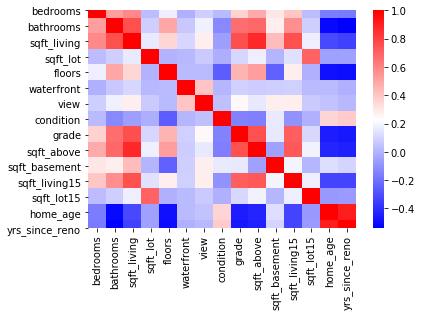

In [51]:
sns.heatmap(predictors.iloc[:,:15].corr(), cmap='bwr')

## Multicollinearity 

In [19]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [53]:
predictors = kc1.drop(columns = ['id', 'date', 'price', 'zipcode', 'lat', 'long',
                                'coords', '3_nearest_neighbors_mean_sqft',
                                'yr_renovated', 'sale_yr', 'yr_built'])

vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(predictors.values, i) for i in range(predictors.shape[1])]
vif['features'] = predictors.columns

vif

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/stats/outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,VIF,features
0,1.821332,bedrooms
1,3.438400,bathrooms
2,inf,sqft_living
3,2.023646,sqft_lot
4,2.422146,floors
...,...,...
82,87.286094,98188
83,175.276546,98198
84,212.686760,98199
85,309.390090,sqrt_grade


In [54]:
predictors.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,sqft_living15,sqft_lot15,home_age,yrs_since_reno,98001,98002,98003,98004,98005,98006,98007,98008,98010,98011,98014,98019,98022,98023,98024,98027,98028,98029,98030,98031,98032,98033,98034,98038,98039,98040,98042,98045,98052,98053,98055,98056,98058,98059,98065,98070,98072,98074,98075,98077,98092,98102,98103,98105,98106,98107,98108,98109,98112,98115,98116,98117,98118,98119,98122,98125,98126,98133,98136,98144,98146,98148,98155,98166,98168,98177,98178,98188,98198,98199,sqrt_grade,9_nearest_neighbors_mean_sqft
0,4.0,2.25,2070,8893,2.0,0,0,4,8,2070,0,2390,7700,28,28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2.828427,2193.333333
1,5.0,3.00,2900,6730,1.0,0,0,5,8,1830,1070,2370,6283,37,37,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2.828427,2040.000000
2,4.0,2.50,3770,10893,2.0,0,2,3,11,3770,0,3710,9685,17,17,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3.316625,2878.888889
3,3.0,3.50,4560,14608,2.0,0,2,3,12,4560,0,4050,14226,25,25,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3.464102,2937.777778
4,3.0,2.50,2550,5376,2.0,0,0,3,9,2550,0,2250,4050,10,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3.000000,2426.666667


## Model

In [55]:
X = predictors
y = kc['price']

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = 43)

In [57]:
scaler = StandardScaler()

X_train_transformed = scaler.fit_transform(X_train)
X_test_transformed = scaler.transform(X_test)

model = LinearRegression()

model.fit(X_train_transformed, y_train)

model.score(X_test_transformed, y_test)

0.8121881152543506

In [60]:
model.coef_

array([-1.54503341e+04,  2.23535156e+04, -1.55682927e+16,  6.79941245e+03,
       -2.15093216e+04,  5.91818382e+04,  3.87340014e+04,  2.09351335e+04,
        8.90440157e+05,  1.40459398e+16,  7.43967630e+15, -5.64950000e+03,
       -3.12250000e+03,  3.63975000e+04, -2.60540000e+04,  2.70429376e+16,
        2.00305453e+16,  2.37460899e+16,  2.42552587e+16,  1.86756684e+16,
        3.06992604e+16,  1.78289367e+16,  2.36816309e+16,  1.29951129e+16,
        2.03357569e+16,  1.57037132e+16,  1.90034661e+16,  2.14401332e+16,
        3.19888062e+16,  1.34658609e+16,  2.87769067e+16,  2.29599897e+16,
        2.48762478e+16,  2.22826123e+16,  2.39383685e+16,  1.61900986e+16,
        2.95010129e+16,  3.26810551e+16,  3.30436933e+16,  1.00116261e+16,
        2.38103648e+16,  3.14704498e+16,  2.08587150e+16,  3.40188215e+16,
        2.81401604e+16,  2.28931985e+16,  2.84604579e+16,  3.06992604e+16,
        3.02062938e+16,  2.57189740e+16,  1.55047850e+16,  2.32909266e+16,
        2.93474790e+16,  

In [58]:
y_pred = model.predict(X_test_transformed)

In [59]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
rmse

153697.40459239745

## Nearest Neighbors

In [11]:
def n_nearest_neighbors_mean_sqft(dataframe, n_neighbors = 3):
    
    """
    
    Takes in a dataframe and number (n_neighbors) of neighbors and adds 
    a column to that dataframe including the mean sqft of the 
    n nearest neighbors to each house
    
    """
    
    lat = dataframe['lat'].to_numpy()
    long = dataframe['long'].to_numpy()     
    sqft = dataframe['sqft_living'].to_numpy()
    
    nearest_neighbors = n_neighbors
    n_neighbors_mean_sqft = []

    for row in range(dataframe.shape[0]): # Outermost loop cycles through all of the rows in the dataframe
        try: # Try/except statements necessary because some index values have been dropped/are missing
            target_coord = dataframe['coords'][row]
            x_target = target_coord[0] # Selecting target x and y elements from the list containing both
            y_target = target_coord[1]
            x_neighbors = np.delete(lat, [row])
            y_neighbors = np.delete(long, [row])

            sqft_neighbors = np.delete(sqft, [row])

            x_dist = (x_target - x_neighbors)**2
            y_dist = (y_target - y_neighbors)**2
            dist = np.sqrt(x_dist + y_dist)

            stacked = np.stack((dist, sqft_neighbors))
            stacked_t = stacked.T # Transposes stacked 2 by n matrix, Col order: [dist  price_neighbors], now is n by 2 matrix

            dist_ordered_stacked = stacked_t[stacked_t[:,0].argsort()] # Sorted n by 2 matrix by dist in ascending order

            n_nearest_sqft = dist_ordered_stacked[:nearest_neighbors, 1] # Slicing out n nearest prices
            mean_n_nearest_sqft = np.mean(n_nearest_sqft)

            n_neighbors_mean_price.append(mean_n_nearest_sqft)

        except:
            print(row)
            continue
    
    col_name = str(n_neighbors) + '_nearest_neighbors_mean_sqft'
    dataframe[col_name] = n_neighbors_mean_sqft
    
    return dataframe

In [17]:
def n_nearest_neighbors_mean_sqft1(dataframe, n_neighbors = 3):
    
    """
    
    Takes in a dataframe and number (n_neighbors) of neighbors and adds 
    a column to that dataframe including the mean sqft of the 
    n nearest neighbors to each house
    
    """
    
    lat = dataframe['lat'].to_numpy()
    long = dataframe['long'].to_numpy()     
    sqft = dataframe['sqft_living'].to_numpy()
    
    nearest_neighbors = n_neighbors
    n_neighbors_mean_sqft = []

    for row in range(dataframe.shape[0]): # Outermost loop cycles through all of the rows in the dataframe
        # Try/except statements necessary because some index values have been dropped/are missing
        target_coord = dataframe['coords'][row]
        x_target = target_coord[0] # Selecting target x and y elements from the list containing both  
        y_target = target_coord[1]
        x_neighbors = np.delete(lat, [row])
        y_neighbors = np.delete(long, [row])
        
        sqft_neighbors = np.delete(sqft, [row])

        x_dist = (x_target - x_neighbors)**2
        y_dist = (y_target - y_neighbors)**2
        dist = np.sqrt(x_dist + y_dist)

        stacked = np.stack((dist, sqft_neighbors))
        stacked_t = stacked.T # Transposes stacked 2 by n matrix, Col order: [dist  price_neighbors], now is n by 2 matrix

        dist_ordered_stacked = stacked_t[stacked_t[:,0].argsort()] # Sorted n by 2 matrix by dist in ascending order

        n_nearest_sqft = dist_ordered_stacked[:nearest_neighbors, 1] # Slicing out n nearest prices
        mean_n_nearest_sqft = np.mean(n_nearest_sqft)

        n_neighbors_mean_sqft.append(mean_n_nearest_sqft)

        
    
    col_name = str(n_neighbors) + '_nearest_neighbors_mean_sqft'
    dataframe[col_name] = n_neighbors_mean_sqft
    
    return dataframe

In [52]:
n_nearest_neighbors_mean_sqft1(kc1, 9)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,sale_yr,home_age,yrs_since_reno,98001,98002,98003,98004,98005,98006,98007,98008,98010,98011,98014,98019,98022,98023,98024,98027,98028,98029,98030,98031,98032,98033,98034,98038,98039,98040,98042,98045,98052,98053,98055,98056,98058,98059,98065,98070,98072,98074,98075,98077,98092,98102,98103,98105,98106,98107,98108,98109,98112,98115,98116,98117,98118,98119,98122,98125,98126,98133,98136,98144,98146,98148,98155,98166,98168,98177,98178,98188,98198,98199,sqrt_grade,coords,3_nearest_neighbors_mean_sqft,9_nearest_neighbors_mean_sqft
0,2591820310,2014-01-06 00:10:00,365000.0,4.0,2.25,2070,8893,2.0,0,0,4,8,2070,0,1986,0,98058,47.4388,-122.162,2390,7700,2014,28,28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2.828427,"[47.4388, -122.162]",2510.000000,2193.333333
1,7974200820,2014-01-21 00:08:00,865000.0,5.0,3.00,2900,6730,1.0,0,0,5,8,1830,1070,1977,0,98115,47.6784,-122.285,2370,6283,2014,37,37,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2.828427,"[47.6784, -122.285]",1900.000000,2040.000000
2,7701450110,2014-01-15 00:08:00,1038000.0,4.0,2.50,3770,10893,2.0,0,2,3,11,3770,0,1997,0,98006,47.5646,-122.129,3710,9685,2014,17,17,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3.316625,"[47.5646, -122.129]",2973.333333,2878.888889
3,9522300010,2015-01-31 00:03:00,1490000.0,3.0,3.50,4560,14608,2.0,0,2,3,12,4560,0,1990,0,98034,47.6995,-122.228,4050,14226,2015,25,25,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3.464102,"[47.6995, -122.228]",3030.000000,2937.777778
4,9510861140,2014-01-14 00:07:00,711000.0,3.0,2.50,2550,5376,2.0,0,0,3,9,2550,0,2004,0,98052,47.6647,-122.083,2250,4050,2014,10,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3.000000,"[47.6647, -122.083]",2160.000000,2426.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17285,627300195,2015-01-03 00:03:00,750000.0,5.0,2.50,3240,9960,1.0,0,1,3,8,2020,1220,1958,0,98008,47.5858,-122.112,2730,10400,2015,57,57,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2.828427,"[47.5858, -122.112]",2990.000000,2896.666667
17286,8819900270,2014-01-20 00:05:00,440000.0,2.0,1.75,1300,4000,2.0,0,0,3,7,1300,0,1948,0,98105,47.6687,-122.288,1350,4013,2014,66,66,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2.645751,"[47.6687, -122.288]",1983.333333,1936.666667
17287,3816300095,2014-01-14 00:05:00,310000.0,3.0,1.00,1050,9876,1.0,0,0,3,7,1050,0,1953,0,98028,47.7635,-122.262,1760,9403,2014,61,61,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2.645751,"[47.7635, -122.262]",2190.000000,2281.111111
17288,122069107,2014-01-04 00:12:00,427500.0,3.0,1.50,1900,43186,1.5,0,0,4,7,1300,600,1971,0,98038,47.4199,-121.990,2080,108028,2014,43,43,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [20]:
np.stack((distance, p))

array([[2.69327236e-01, 1.30056296e-01, 2.68924692e-01, ...,
        3.39750040e-01, 1.73035285e-01, 3.36650917e-01],
       [8.65000000e+05, 1.03800000e+06, 1.49000000e+06, ...,
        3.10000000e+05, 4.27500000e+05, 3.48000000e+05]])

In [ ]:
stacked = np.stack((distance, price))
        stacked_transposed = stacked.T
        print(stacked_transposed)

In [147]:
np.hstack((np.array(list(dist)), price))

ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 1 dimension(s) and the array at index 1 has 2 dimension(s)

In [24]:
test = np.array([1,2,4,3,5,6,7])


In [22]:
np.delete(test, [0])

array([2, 3, 4, 5, 6, 7])

In [25]:
np.sort(test)

array([1, 2, 3, 4, 5, 6, 7])

In [48]:
a = np.array([[9, 2, 3],
           [4, 5, 6],
           [7, 0, 5],
           [1, 2, 3] ])

In [30]:
a

array([[9, 2, 3],
       [4, 5, 6],
       [7, 0, 5]])

In [33]:
np.sort(a.view('i8,i8,i8'), order=['f1'], axis=0).view(np.int)

array([[7, 0, 5],
       [9, 2, 3],
       [4, 5, 6]])

In [26]:
b = np.array([[1.0,2.0,3.0,4.0]])
c = np.array([[7.1,6.2,8.3,9.4]])
b.shape
c.shape

(1, 4)

In [52]:
np.hstack((b,c))

ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 1 dimension(s) and the array at index 1 has 2 dimension(s)

In [61]:
d = np.concatenate((c,b))
d

array([[6, 7, 8, 9],
       [1, 2, 3, 4]])

In [62]:
np.sort(d.view('i8,i8,i8,i8'), order=['f1'], axis=0).view(np.int)

array([[1, 2, 3, 4],
       [6, 7, 8, 9]])

In [63]:
b.T

array([[1],
       [2],
       [3],
       [4]])

In [27]:
e = np.hstack((c.T, b.T))
e

array([[7.1, 1. ],
       [6.2, 2. ],
       [8.3, 3. ],
       [9.4, 4. ]])

In [105]:
np.sort(e.view('f8,f8'), order=['f0'], axis=0).view(np.float)

array([[3.0e-323, 9.9e-324],
       [3.5e-323, 4.9e-324],
       [4.0e-323, 1.5e-323],
       [4.4e-323, 2.0e-323]])

In [108]:
np.argsort(e, axis = 0)

array([[1, 0],
       [0, 1],
       [2, 2],
       [3, 3]])

In [30]:
e[e[:,0].argsort()]  # THIS WORKS FOR SORTING TWO COLUMN MATRIX, this example sorts using first col as key

array([[6.2, 2. ],
       [7.1, 1. ],
       [8.3, 3. ],
       [9.4, 4. ]])

In [37]:
j = np.array([1.0,2.0, 3.0, 4.0])
k = np.array([9.1, 0.3, 1.04, 5.0])
jk = np.stack((j,k))
jk

array([[1.  , 2.  , 3.  , 4.  ],
       [9.1 , 0.3 , 1.04, 5.  ]])

In [40]:
jaker = jk.T
jaker

array([[1.  , 9.1 ],
       [2.  , 0.3 ],
       [3.  , 1.04],
       [4.  , 5.  ]])

In [57]:
jayb = jaker[jaker[:,1].argsort()]
jayb

array([[2.  , 0.3 ],
       [3.  , 1.04],
       [4.  , 5.  ],
       [1.  , 9.1 ]])

In [58]:
jayb[:3, 1]

array([0.3 , 1.04, 5.  ])

## Dummies

In [59]:
ohe = pd.get_dummies(kc['zipcode']) #step 2 of engineering/cleaning before adding nnp cols
kc = kc.join(ohe)

,98001,98002,98003,98004,98005,98006,98007,98008,98010,98011,98014,98019,98022,98023,98024,98027,98028,98029,98030,98031,98032,98033,98034,98038,98039,98040,98042,98045,98052,98053,98055,98056,98058,98059,98065,98070,98072,98074,98075,98077,98092,98102,98103,98105,98106,98107,98108,98109,98112,98115,98116,98117,98118,98119,98122,98125,98126,98133,98136,98144,98146,98148,98155,98166,98168,98177,98178,98188,98198,98199
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17285,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
17286,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
17287,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
17288,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [60]:
kc = kc.join(ohe)

In [100]:
kc.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,sale_yr,home_age,yrs_since_reno,98001,98002,98003,98004,98005,98006,98007,98008,98010,98011,98014,98019,98022,98023,98024,98027,98028,98029,98030,98031,98032,98033,98034,98038,98039,98040,98042,98045,98052,98053,98055,98056,98058,98059,98065,98070,98072,98074,98075,98077,98092,98102,98103,98105,98106,98107,98108,98109,98112,98115,98116,98117,98118,98119,98122,98125,98126,98133,98136,98144,98146,98148,98155,98166,98168,98177,98178,98188,98198,98199,sqrt_grade
0,2591820310,2014-01-06 00:10:00,365000.0,4.0,2.25,2070,8893,2.0,0,0,4,8,2070,0,1986,0,98058,47.4388,-122.162,2390,7700,2014,28,28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2.828427
1,7974200820,2014-01-21 00:08:00,865000.0,5.0,3.00,2900,6730,1.0,0,0,5,8,1830,1070,1977,0,98115,47.6784,-122.285,2370,6283,2014,37,37,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2.828427
2,7701450110,2014-01-15 00:08:00,1038000.0,4.0,2.50,3770,10893,2.0,0,2,3,11,3770,0,1997,0,98006,47.5646,-122.129,3710,9685,2014,17,17,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3.316625
3,9522300010,2015-01-31 00:03:00,1490000.0,3.0,3.50,4560,14608,2.0,0,2,3,12,4560,0,1990,0,98034,47.6995,-122.228,4050,14226,2015,25,25,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3.464102
4,9510861140,2014-01-14 00:07:00,711000.0,3.0,2.50,2550,5376,2.0,0,0,3,9,2550,0,2004,0,98052,47.6647,-122.083,2250,4050,2014,10,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3.000000


## Visualizations

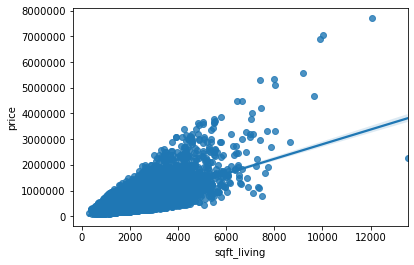

In [18]:
sns.regplot(kc['sqft_living'], kc['price'])

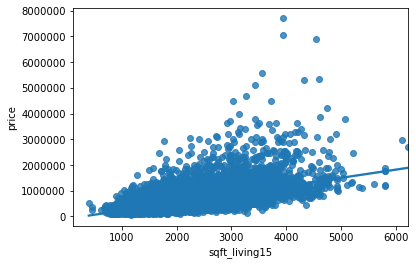

In [31]:
sns.regplot(kc['sqft_living15'], kc['price'])

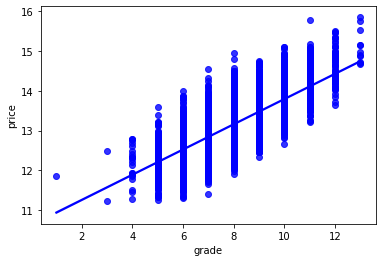

In [39]:
sns.regplot(kc['grade'], np.log(kc['price']), color = 'blue')

In [95]:
scaler = StandardScaler()
final_df = pd.DataFrame(data=scaler.fit_transform(predictors), columns=predictors.columns)

In [96]:
model = LinearRegression()
model = model.fit(final_df, kc['price'])

In [97]:
import pickle


pickle_out = open("kc_house_model.pickle","wb")
pickle.dump(model, pickle_out)
pickle_out.close()

pickle_out = open("kc_house_scaler.pickle","wb")
pickle.dump(scaler, pickle_out)
pickle_out.close()